In [1]:
# Set spark environments
import os
import sys
#os.environ["SPARK_HOME"] = '/home/ypang6/anaconda3/lib/python3.7/site-packages/pyspark'
#os.environ["PYTHONPATH"] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
os.environ["SPARK_HOME"]="/usr/local/spark"
os.environ["PYLIB"]=os.environ["SPARK_HOME"]+"/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
os.environ["PYSPARK_PYTHON"] = "/home/anaconda3/bin/python" 
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[2] pyspark-shell "

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
#####
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Window
#####

In [3]:
spark = SparkSession \
        .builder \
        .appName("Terminal_Area_Flight_Data_Query") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

# recType3 Data
## Custom schema of the data
### References to IFF_2.15_Specs_Sherlock.doc

In [4]:
myschema = StructType([
    StructField("recType", ShortType(), True),  #1  //track point record type number
    StructField("recTime", StringType(), True),  #2  //seconds since midnigght 1/1/70 UTC
    StructField("fltKey", LongType(), True),  #3  //flight key
    StructField("bcnCode", IntegerType(), True),  #4  //digit range from 0 to 7
    StructField("cid", IntegerType(), True),  #5  //computer flight id
    StructField("Source", StringType(), True),  #6  //source of the record 
    StructField("msgType", StringType(), True),  #7
    StructField("acId", StringType(), True),  #8  //call sign
    StructField("recTypeCat", StringType(), True),  #9
    StructField("lat", DoubleType(), True),  #10
    StructField("lon", DoubleType(), True),  #11 
    StructField("alt", DoubleType(), True),  #12  //in 100s of feet
    StructField("significance", ShortType(), True),  #13 //digit range from 1 to 10
    StructField("latAcc", DoubleType(), True),  #14
    StructField("lonAcc", DoubleType(), True),  #15
    StructField("altAcc", DoubleType(), True),  #16
    StructField("groundSpeed", IntegerType(), True),  #17 //in knots
    StructField("course", DoubleType(), True),  #18  //in degrees from true north
    StructField("rateOfClimb", DoubleType(), True),  #19  //in feet per minute
    StructField("altQualifier", StringType(), True),  #20  //Altitude qualifier (the “B4 character”)
    StructField("altIndicator", StringType(), True),  #21  //Altitude indicator (the “C4 character”)
    StructField("trackPtStatus", StringType(), True),  #22  //Track point status (e.g., ‘C’ for coast)
    StructField("leaderDir", IntegerType(), True),  #23  //int 0-8 representing the direction of the leader line
    StructField("scratchPad", StringType(), True),  #24
    StructField("msawInhibitInd", ShortType(), True),  #25 // MSAW Inhibit Indicator (0=not inhibited, 1=inhibited)
    StructField("assignedAltString", StringType(), True),  #26 
    StructField("controllingFac", StringType(), True),  #27
    StructField("controllingSec", StringType(), True),  #28
    StructField("receivingFac", StringType(), True),  #29
    StructField("receivingSec", StringType(), True),  #30
    StructField("activeContr", IntegerType(), True),  #31  // the active control number
    StructField("primaryContr", IntegerType(), True),  #32  //The primary(previous, controlling, or possible next)controller number
    StructField("kybrdSubset", StringType(), True),  #33  //identifies a subset of controller keyboards
    StructField("kybrdSymbol", StringType(), True),  #34  //identifies a keyboard within the keyboard subsets
    StructField("adsCode", IntegerType(), True),  #35  //arrival departure status code
    StructField("opsType", StringType(), True),  #36  //Operations type (O/E/A/D/I/U)from ARTS and ARTS 3A data
    StructField("airportCode", StringType(), True),  #37 
    StructField("trackNumber", IntegerType(), True),  #38
    StructField("tptReturnType", StringType(), True),  #39
    StructField("modeSCode", StringType(), True),  #40
    StructField("sensorTrackNumberList", StringType(), True), #41 //a list of sensor/track number combinations
    StructField("spi", StringType(), True),  #42 // representing the Ident feature
    StructField("dvs", StringType(), True), #43 // indicate the aircraft is within a suppresion volumn area
    StructField("dupM3a", StringType(), True),  #44 // indicate 2 aircraft have the same mode 3a code
    StructField("tid", StringType(), True),  #45 //Aircraft Ident entered by pilot

])

In [5]:
date = 20190801

In [6]:
import glob
file_path = glob.glob("/home/pzhao28/Documents/Research/Software/data/ZTL/IFF_ZTL_{}*.csv".format(date))[0]

In [7]:
df = spark.read.csv(file_path, header=False, sep=",", schema=myschema)

In [8]:
df.printSchema()

root
 |-- recType: short (nullable = true)
 |-- recTime: string (nullable = true)
 |-- fltKey: long (nullable = true)
 |-- bcnCode: integer (nullable = true)
 |-- cid: integer (nullable = true)
 |-- Source: string (nullable = true)
 |-- msgType: string (nullable = true)
 |-- acId: string (nullable = true)
 |-- recTypeCat: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- alt: double (nullable = true)
 |-- significance: short (nullable = true)
 |-- latAcc: double (nullable = true)
 |-- lonAcc: double (nullable = true)
 |-- altAcc: double (nullable = true)
 |-- groundSpeed: integer (nullable = true)
 |-- course: double (nullable = true)
 |-- rateOfClimb: double (nullable = true)
 |-- altQualifier: string (nullable = true)
 |-- altIndicator: string (nullable = true)
 |-- trackPtStatus: string (nullable = true)
 |-- leaderDir: integer (nullable = true)
 |-- scratchPad: string (nullable = true)
 |-- msawInhibitInd: short (nullable = true)
 |

### Select Columns

In [9]:
cols = ['recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed']
df_rec3 = df.select(*cols).filter(df['recType']==3).withColumn("recTime", df['recTime'].cast(IntegerType()))

In [10]:
df_rec3.show()

+-------+----------+-----+--------+---------+----+-----------+
|recType|   recTime| acId|     lat|      lon| alt|groundSpeed|
+-------+----------+-----+--------+---------+----+-----------+
|      3|1564634988|SKQ74|36.10444|-79.43917|23.0|        200|
|      3|1564634999|SKQ74|36.11417|-79.43611|26.0|        200|
|      3|1564635012|SKQ74|36.12389| -79.4325|29.0|        171|
|      3|1564635024|SKQ74|36.13333|-79.42889|32.0|        180|
|      3|1564635036|SKQ74|36.14278|-79.42583|37.0|        178|
|      3|1564635048|SKQ74| 36.1525|-79.42278|40.0|        183|
|      3|1564635059|SKQ74|36.16083|   -79.42|43.0|        172|
|      3|1564635072|SKQ74|36.17139|-79.41667|46.0|        184|
|      3|1564635084|SKQ74|36.18056|-79.41389|48.0|        172|
|      3|1564635096|SKQ74|36.19028|-79.41056|51.0|        184|
|      3|1564635108|SKQ74|    36.2|-79.40722|54.0|        184|
|      3|1564635120|SKQ74|   36.21|-79.40389|58.0|        189|
|      3|1564635132|SKQ74|36.21944|-79.40056|60.0|     

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

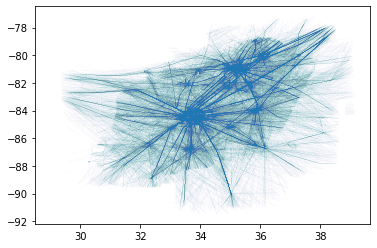

In [12]:
pdf_rec3 = df_rec3.toPandas()
plt.scatter(pdf_rec3['lat'], pdf_rec3['lon'], s=0.00001)

# recType2 data

In [13]:
from pkg_resources.extern import packaging

def parse_version(v):
    try:
        return packaging.version.Version(v)
    except packaging.version.InvalidVersion:
        return packaging.version.LegacyVersion(v)

In [14]:
def read_iff_file(filename, record_types=3, callsigns=None, chunksize=50000, encoding='latin-1'):
    """
    Read IFF file and return data frames for requested record types
    
    From IFF 2.15 specification, record types include:
    2. header
    3. track point
    4. flight plan
    5. data source program
    6. sectorization
    7. minimum safe altitude
    8. flight progress
    9. aircraft state
    Parameters
    ----------
    filename : str
        File to read
    record_types : int, sequence of ints, or 'all'
        Record types to return
    callsigns : None, string, or list of strings
        If None, return records for all aircraft callsigns.
        Otherwise, only return records that match the given callsign
        (in the case of a single string) or match one of the specified
        callsigns (in the case of a list of strings).
    chunksize: int
        Number of rows that are read at a time by pd.read_csv.  This
        limits memory usage when working with large files, as we can
        extract out the desired rows from each chunk, intead of
        reading everything into one large DataFrame and then taking a
        subset.
    encoding: str
        Encoding argument passed on to open and pd.read_csv.  Using
        'latin-1' instead of the default will suppress errors that
        might otherwise occur with minor data corruption.  See
        http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html
    
    Returns
    -------
    DataFrame or dict of DataFrames
       If record_types is a scalar, return a DataFrame containing the
       data for that record type only.  Otherwise, return a dictionary
       mapping each requested record type to a corresponding DataFrame.
    """
    # Note default record_type of 3 (track point) is used for
    # consistency with the behavior of other functions that expect
    # flight tracking data

    # Determine file format version.  This is in record type 1, which
    # for now we assume to occur on the first line.
    with open(filename, 'r') as f:
        version = parse_version(f.readline().split(',')[2])

    # Columns for each record type, from version 2.6 specification.
    cols = {0:['recType','comment'],
            1:['recType','fileType','fileFormatVersion'],
            2:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','opsType','estOrig','estDest'],
            3:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','groundSpeed','course','rateOfClimb','altQualifier','altIndicator','trackPtStatus','leaderDir','scratchPad','msawInhibitInd','assignedAltString','controllingFac','controllingSeg','receivingFac','receivingSec','activeContr','primaryContr','kybrdSubset','kybrdSymbol','adsCode','opsType','airportCode'],
            4:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','altcode','alt','maxAlt','assignedAltString','requestedAltString','route','estTime','fltCat','perfCat','opsType','equipList','coordinationTime','coordinationTimeType','leaderDir','scratchPad1','scratchPad2','fixPairScratchPad','prefDepArrRoute','prefDepRoute','prefArrRoute'],
            5:['recType','dataSource','programName','programVersion'],
            6:['recType','recTime','Source','msgType','rectypeCat','sectorizationString'],
            7:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','msawtype','msawTimeCat','msawLocCat','msawMinSafeAlt','msawIndex1','msawIndex2','msawVolID'],
            8:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','depTime','depTimeType','arrTime','arrTimeType'],
            9:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','pitchAngle','trueHeading','rollAngle','trueAirSpeed','fltPhaseIndicator'],
            10:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','configType','configSpec']}

    # For newer versions, additional columns are supported.  However,
    # this code could be commented out, and it should still be
    # compatible with newer versions, but just ignoring the additional
    # columns.
    if version >= parse_version('2.13'):
        cols[2] += ['modeSCode']
        cols[3] += ['trackNumber','tptReturnType','modeSCode']
        cols[4] += ['coordinationPoint','coordinationPointType','trackNumber','modeSCode']
    if version >= parse_version('2.15'):
        cols[3] += ['sensorTrackNumberList','spi','dvs','dupM3a','tid']

    # Determine the record type of each row
    with open(filename, 'r', encoding=encoding) as f:
        # An alternative, using less memory, would be to directly
        # create skiprows indices for a particular record type, using
        # a comprehension on enumerate(f); however, that would not
        # allow handling multiple record types.
        line_record_types = [int(line.split(',')[0]) for line in f]

    # Determine which record types to retrieve, and whether the result
    # should be a scalar or dict:
    if record_types == 'all':
        record_types = np.unique(line_record_types)
        scalar_result = False
    elif hasattr(record_types, '__getitem__'):
        scalar_result = False
    else:
        record_types = [record_types]
        scalar_result = True

    if callsigns is not None:
        callsigns = list(np.atleast_1d(callsigns))


    data_frames = dict()
    for record_type in record_types:
        # Construct list of rows to skip:
        skiprows = [i for i,lr in enumerate(line_record_types) if lr != record_type]
        
        # Passing usecols is necessary because for some records, the
        # actual data has extraneous empty columns at the end, in which
        # case the data does not seem to get read correctly without
        # usecols
        if callsigns is None:
            df = pd.concat((chunk for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)
        else:
            df = pd.concat((chunk[chunk['AcId'].isin(callsigns)] for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)

        # For consistency with other PARA-ATM data:
        df.rename(columns={'recTime':'time',
                           'AcId':'callsign',
                           'coord1':'latitude',
                           'coord2':'longitude',
                           'alt':'altitude',
                           'rateOfClimb':'rocd',
                           'groundSpeed':'tas',
                           'course':'heading'},
                  inplace=True)

        #if 'time' in df:
            #df['time'] = pd.to_datetime(df['time'], unit='s')
        if 'altitude' in df:
            df['altitude'] *= 100 # Convert 100s ft to ft

        # Store to dict of data frames
        data_frames[record_type] = df

    if scalar_result:
        result = data_frames[record_types[0]]
    else:
        result = data_frames

    return result

In [15]:
pd_df_rec2 = read_iff_file(file_path, record_types=2, chunksize = 1e6)

In [16]:
cols_rec2 = ['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']
pd_df_2 = pd_df_rec2[['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']]

In [17]:
#t = pd.to_datetime(1561350792, format='%Y%m%d')

In [18]:
pd_df_2.head()

,recType,time,callsign,acType,Orig,Dest
0,2,1.564635e+09,SKQ74,PC12,KBUY,KIAD
1,2,1.564633e+09,DAL2681,A321,KATL,KRDU
2,2,1.564632e+09,LN441PC,LJ35,OTK337060,KGBG
3,2,1.564632e+09,DAL2690,B752,37.016667/-80.383333,KATL
4,2,1.564632e+09,UPS9603,B752,ATL130032,KSDF


# Data Processing

In [19]:
pd.options.display.max_rows = 1000

In [20]:
### pandas
pdf_rec3['next_acId'] = pdf_rec3['acId'].shift(-1)
pdf_rec3['previous_acId'] = pdf_rec3['acId'].shift(1)
pdf_rec3['init_ac'] = pdf_rec3['acId'] != pdf_rec3['previous_acId']
pdf_rec3['end_ac'] = pdf_rec3['acId'] != pdf_rec3['next_acId']
pdf_rec3.drop(columns=['previous_acId', 'next_acId'])

,recType,recTime,acId,lat,lon,alt,groundSpeed,init_ac,end_ac
0,3,1564634988,SKQ74,36.10444,-79.43917,23.0,200,True,False
1,3,1564634999,SKQ74,36.11417,-79.43611,26.0,200,False,False
2,3,1564635012,SKQ74,36.12389,-79.43250,29.0,171,False,False
3,3,1564635024,SKQ74,36.13333,-79.42889,32.0,180,False,False
4,3,1564635036,SKQ74,36.14278,-79.42583,37.0,178,False,False
...,...,...,...,...,...,...,...,...,...
1984649,3,1564721673,FDX105,34.18667,-87.98472,309.0,449,False,False
1984650,3,1564721685,FDX105,34.19889,-88.01111,304.0,453,False,False
1984651,3,1564721697,FDX105,34.21139,-88.03750,300.0,455,False,False
1984652,3,1564721709,FDX105,34.22389,-88.06389,295.0,455,False,False


In [21]:
### pyspark
Windowspec=Window.orderBy("recType")
df_rec3 = df_rec3.withColumn('prev_acId', F.lag(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('next_acId', F.lead(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('init_ac', F.when(df_rec3.acId == df_rec3.prev_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('end_ac', F.when(df_rec3.acId == df_rec3.next_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('index', F.row_number().over(Windowspec))
df_rec3.drop('prev_acId')
cols = ['index','recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed', 'init_ac', 'end_ac']

In [22]:
ZTL_airports = ['KATL', 'KCHA', 'KGSO', 'KGSP', 'KHKY', 'KHSV']
airportsCoord = {'KATL':(33.6407, -84.4277), \
                 'KCHA':(35.0374, -85.1970), \
                 'KSGO':(36.1044, -79.9352), \
                 'KGSP':(34.8959, -82.2172), \
                 'KHKY':(35.7422, -81.3893), \
                 'KHSV':(34.6403, -86.7757)}

## extract arrival

In [23]:
schema = StructType([
    StructField('time', StringType(), True),
    StructField('hour', StringType(), True),
    StructField('acId', StringType(), True),
    StructField('lat', DoubleType(), True),
    StructField('lon', DoubleType(), True),
    StructField('alt', DoubleType(), True),
    StructField('Dest', StringType(), True),
    StructField('acType', StringType(), True),
    StructField('arr_time', StringType(), True)
    #StructField('time_100', StringType(), True),
    #StructField('time_40', StringType(), True)
])

In [24]:
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6367 * dist * 1000 #6367 for distance in KM for miles use 3958
    return m

In [25]:
out_circl = 370400
in_circl = 74080

In [26]:
def num_ac_ahead(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time-600, current_time)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [27]:
def num_ac_behind(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time, current_time+600)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [28]:
### pandas
columns = ['recTime', 'time','hour','acId', 'lat', 'lon', 'alt', 'Dest','distance', 'acType','groundSpeed', 'num_ac_ahead', 'num_ac_behind', 'arr_time', 'time100','time40']
pdf3 = pd.DataFrame([], columns=columns)
for index, row in pdf_rec3.iterrows():
    if row['init_ac']:
        init_index = index
        timestamp = row.recTime
    if row.end_ac:
        if row.alt <= 50:
            end_index = index
            tmp_pdf = pdf_rec3.iloc[init_index:end_index+1, :]
            tmp_dest = pd_df_2[pd_df_2['time']==timestamp]['Dest'].to_string(index=False).strip()
            acType = pd_df_2[pd_df_2['time']==timestamp]['acType'].to_string(index=False).strip()
            if tmp_dest in airportsCoord.keys():
                tmp_pdf.loc[:,'Dest'] = tmp_dest
                tmp_pdf.loc[:,'acType'] = acType
                tmp_pdf.loc[:,'dest_lat'] = airportsCoord[tmp_dest][0]
                tmp_pdf.loc[:,'dest_lon'] = airportsCoord[tmp_dest][1]
                tmp_pdf.loc[:,'distance'] = haversine_vectorize(tmp_pdf['lon'], tmp_pdf['lat'], tmp_pdf['dest_lon'], tmp_pdf['dest_lat'])
                #tmp_pdf = tmp_pdf[tmp_pdf['distance'] <= 185200]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] <= out_circl]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] >= in_circl]
                tmp_pdf_out = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl - 20000, out_circl)]
                tmp_pdf_in = tmp_pdf.loc[tmp_pdf['distance'].between(in_circl,in_circl + 20000)]
                if not tmp_pdf_in.empty and not tmp_pdf_out.empty:
                    tmp_time = pd.to_datetime(tmp_pdf.head(1)['recTime'].values[0]-14400, unit='s')
                    tmp_pdf.loc[:,'time'] = tmp_time
                    #tmp_pdf.loc[:,'time'] = tmp_pdf.head(1)['recTime']
                    tmp_pdf.loc[:,'hour'] = tmp_time.hour
                    in_time = tmp_pdf.head(1)['recTime'].values[0]
                    out_time = tmp_pdf.tail(1)['recTime'].values[0]
                    center_time = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl/2-100000, out_circl/2)].head(1)['recTime'].values[0]
                    tmp_pdf.loc[:,'arr_time'] = out_time - in_time
                    tmp_pdf.loc[:,'time40'] = out_time
                    tmp_pdf.loc[:,'time100'] = center_time
                    first_time = tmp_pdf.head(1)['recTime'].values[0]
                    number_ahead = num_ac_ahead(in_time, tmp_dest)
                    number_behind = num_ac_behind(in_time, tmp_dest)
                    tmp_pdf.loc[:,'num_ac_ahead'] = number_ahead
                    tmp_pdf.loc[:,'num_ac_behind'] = number_behind
                    pdf3 = pdf3.append(tmp_pdf[tmp_pdf['recTime']==first_time][columns])
                    print("processed aircraft: {}".format(pdf3.shape[0]),end='\r')
                    sys.stdout.flush()


/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [53]:
pdf3.head(1000)

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40
1781483,1564708185,2019-08-01 21:09:45,21,DAL819,32.60389,-88.21000,310.0,KATL,370358.237583,MD90,478,240,221,1846,1564709374,1564710031
1554041,1564699814,2019-08-01 18:50:14,18,SWA442,36.00889,-81.58667,340.0,KATL,369317.657601,B737,409,285,280,1426,1564700679,1564701240
1529633,1564698756,2019-08-01 18:32:36,18,DAL1914,35.97222,-81.55972,360.0,KATL,368209.590904,A320,411,290,274,1528,1564699670,1564700284
110332,1564656276,2019-08-01 06:44:36,6,SWA1302,36.72000,-82.88194,400.0,KATL,369853.321938,B737,468,140,175,1303,1564657070,1564657579
1060458,1564684335,2019-08-01 14:32:15,14,DAL376,30.32556,-84.13111,360.0,KATL,369453.848700,B739,470,339,341,1600,1564685156,1564685935
1212321,1564688652,2019-08-01 15:44:12,15,DAL1317,31.05833,-81.96583,182.0,KATL,368432.041351,MD88,424,321,321,1805,1564689728,1564690457
120697,1564656542,2019-08-01 06:49:02,6,DAL839,36.00750,-81.58806,360.0,KATL,369120.225038,A320,438,166,176,1311,1564657335,1564657853
1466547,1564696678,2019-08-01 17:57:58,17,DAL2465,36.58278,-82.53083,280.0,KATL,369601.214632,MD90,451,330,312,1528,1564697496,1564698206
574806,1564670487,2019-08-01 10:41:27,10,SKW3874,34.04778,-80.47111,283.0,KATL,367942.486976,CRJ2,352,402,379,1565,1564671423,1564672052
1224369,1564688697,2019-08-01 15:44:57,15,CNS257,36.80306,-81.71889,240.0,KCHA,369377.992351,PC12,245,305,323,2260,1564690161,1564690957


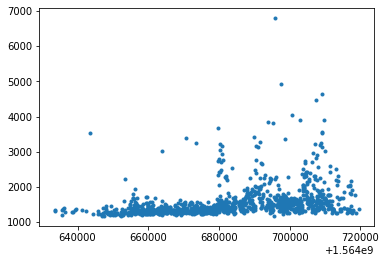

In [54]:
arr_t = pdf3['arr_time'].values
time_list = pdf3['recTime'].values
plt.scatter(time_list, arr_t, marker='.')

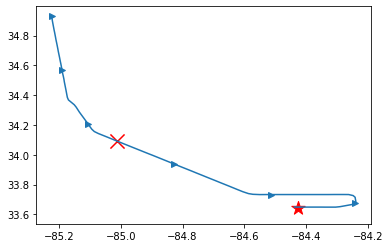

In [55]:
EDV3471_tr = pdf_rec3.loc[pdf_rec3['acId']=='EDV3471']
EDV3471_tr = EDV3471_tr.loc[EDV3471_tr['recTime'].between(1564702750-2000,1564702750+3000)]
plt.plot(EDV3471_tr['lon'], EDV3471_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in EDV3471_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

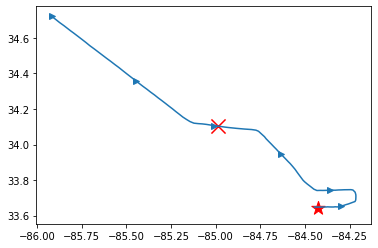

In [56]:
DAL2075_tr = pdf_rec3.loc[pdf_rec3['acId']=='DAL2075']
DAL2075_tr = DAL2075_tr.loc[DAL2075_tr['recTime'].between(1564684886,1564684886+3000)]
plt.plot(DAL2075_tr['lon'], DAL2075_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in DAL2075_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

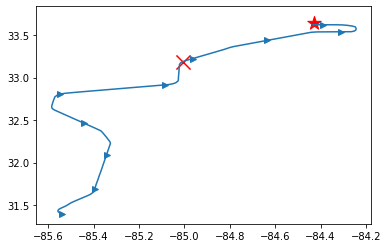

In [57]:
SKW3899_tr = pdf_rec3.loc[pdf_rec3['acId']=='SKW3899']
SKW3899_tr = SKW3899_tr.loc[SKW3899_tr['recTime'].between(1564688772-1000,1564688772+3000)]
plt.plot(SKW3899_tr['lon'], SKW3899_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in SKW3899_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

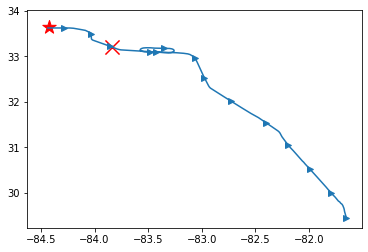

In [58]:
DAL1827_tr = pdf_rec3.loc[pdf_rec3['acId']=='DAL1827']
DAL1827_tr = DAL1827_tr.loc[DAL1827_tr['recTime'].between(1564688880,1564688880+5000)]
plt.plot(DAL1827_tr['lon'], DAL1827_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in DAL1827_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

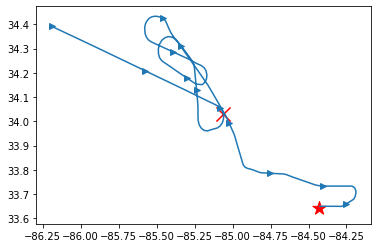

In [59]:
SWA1289_tr = pdf_rec3.loc[pdf_rec3['acId']=='SWA1289']
SWA1289_tr = SWA1289_tr.loc[SWA1289_tr['recTime'].between(1564680604,1564680604+3000)]
plt.plot(SWA1289_tr['lon'], SWA1289_tr['lat'], marker = '>', markevery=20)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker = '*', color='r', s = 200)
for index, row in SWA1289_tr.iterrows():
    distance2airport = haversine_vectorize(row['lon'], row['lat'], airportsCoord['KATL'][1], airportsCoord['KATL'][0])
    if distance2airport<74080:
        plt.scatter(row['lon'], row['lat'], marker='x', color='r', s=200)
        break

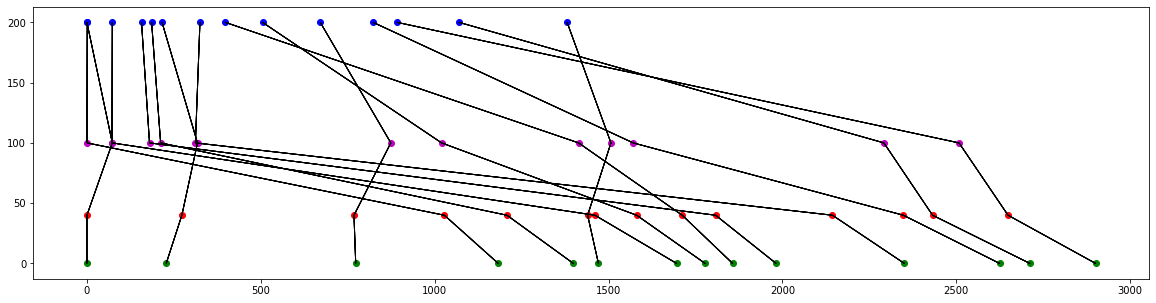

In [60]:
busy = pdf3.loc[pdf3['recTime'].between(1.5646e9+80000,1.5646e9+81500)]
busy_runway1 = []
land_t = []

for index, row in busy.iterrows():
    acTr = pdf_rec3.loc[pdf_rec3['acId']==row['acId']]
    end_row = acTr.loc[acTr['end_ac']==True]
    check = end_row.loc[end_row['lat'].between(33.64, 33.65)]
    if check.empty:
        continue
    busy_runway1.append(row['acId'])
    end_rows = acTr.loc[check.index[0]-10:check.index[0]]
    end_rows = end_rows.loc[end_rows['alt']==check['alt'].values[0]]
    land_t.append(end_rows.head(1)['recTime'].values[0])
    
busy = busy[busy['acId'].isin(busy_runway1)]
busy['land_t'] = land_t
fig, ax = plt.subplots(figsize=(20,5))
#plt.scatter(busy['recTime']-min(busy['recTime']),np.zeros(len(busy)), marker = '.')
#plt.scatter(busy['recTime'], busy['arr_time'])
#plt.scatter(busy['time40']-min(busy['time40']), np.ones(len(busy)), marker = '.')
time200 = busy['recTime']
time100 = busy['time100']
time40 = busy['time40']
time0 = busy['land_t']
for i, time in enumerate(time200):
    time200_tmp = time-min(time200)
    time100_tmp = time100.values[i]-min(time100)
    time40_tmp = time40.values[i]-min(time40)
    time0_tmp = time0.values[i] - min(time0)
    ax.scatter(time200_tmp,200,marker='o', color='b')
    ax.scatter(time100_tmp,100,marker='o', color='m')
    ax.scatter(time40_tmp,40,marker='o', color='r')
    ax.scatter(time0_tmp,0,marker='o', color = 'g')
    ar1 = plt.arrow(time200_tmp, 200, time100_tmp-time200_tmp, -100)
    ar2 = plt.arrow(time100_tmp, 100, time40_tmp-time100_tmp, -60)
    ar3 = plt.arrow(time40_tmp, 40, time0_tmp - time40_tmp, -40)
    ax.add_artist(ar1)
    ax.add_artist(ar2)
    ax.add_artist(ar3)
    

In [61]:
time40 - min(time40)

1000184    2432
945887     1028
970139     1712
998586     2348
989655     2144
920203      768
958616     1208
961608     1440
999380     2649
969193     1461
974344     1808
971949     1581
906667        0
917920      273
Name: time40, dtype: object

In [62]:
busy

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40,land_t
1000184,1564681116,2019-08-01 13:38:36,13,DAL186,36.32806,-86.83083,354.0,KATL,370174.200096,B77L,463,365,352,2769,1564683124,1564683885,1564684882
945887,1564680047,2019-08-01 13:20:47,13,DAL2454,34.75667,-88.21889,382.0,KATL,369830.168932,B752,478,362,369,2434,1564680832,1564682481,1564683353
970139,1564680444,2019-08-01 13:27:24,13,DAL1302,36.45583,-86.58278,287.0,KATL,369163.355049,B712,462,374,366,2721,1564682246,1564683165,1564684027
998586,1564680869,2019-08-01 13:34:29,13,DAL1193,36.20167,-87.00556,310.0,KATL,368965.151779,MD88,486,373,367,2932,1564682403,1564683801,1564684795
989655,1564680371,2019-08-01 13:26:11,13,EDV3363,34.75250,-88.19167,330.0,KATL,367326.680480,CRJ9,487,376,375,3226,1564681144,1564683597,1564684521
920203,1564680717,2019-08-01 13:31:57,13,N500RR,35.26583,-80.98333,38.0,KATL,363595.209646,F2TH,256,372,362,1504,1564681706,1564682221,1564682943
958616,1564680232,2019-08-01 13:23:52,13,DPJ26,36.04000,-87.21250,366.0,KATL,368199.514848,CL60,476,374,369,2429,1564681044,1564682661,1564683569
961608,1564681427,2019-08-01 13:43:47,13,DLH444,36.72361,-82.91000,360.0,KATL,369264.982072,A333,460,365,332,1466,1564682339,1564682893,1564683641
999380,1564680938,2019-08-01 13:35:38,13,DAL1557,36.32417,-86.79389,370.0,KATL,367849.976127,B752,481,371,364,3164,1564683340,1564684102,1564685071
969193,1564680119,2019-08-01 13:21:59,13,DAL1044,34.75583,-88.21472,318.0,KATL,369439.520628,B752,458,367,372,2795,1564680904,1564682914,1564683866


In [63]:
pdf3.head(1000)

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40
1781483,1564708185,2019-08-01 21:09:45,21,DAL819,32.60389,-88.21000,310.0,KATL,370358.237583,MD90,478,240,221,1846,1564709374,1564710031
1554041,1564699814,2019-08-01 18:50:14,18,SWA442,36.00889,-81.58667,340.0,KATL,369317.657601,B737,409,285,280,1426,1564700679,1564701240
1529633,1564698756,2019-08-01 18:32:36,18,DAL1914,35.97222,-81.55972,360.0,KATL,368209.590904,A320,411,290,274,1528,1564699670,1564700284
110332,1564656276,2019-08-01 06:44:36,6,SWA1302,36.72000,-82.88194,400.0,KATL,369853.321938,B737,468,140,175,1303,1564657070,1564657579
1060458,1564684335,2019-08-01 14:32:15,14,DAL376,30.32556,-84.13111,360.0,KATL,369453.848700,B739,470,339,341,1600,1564685156,1564685935
1212321,1564688652,2019-08-01 15:44:12,15,DAL1317,31.05833,-81.96583,182.0,KATL,368432.041351,MD88,424,321,321,1805,1564689728,1564690457
120697,1564656542,2019-08-01 06:49:02,6,DAL839,36.00750,-81.58806,360.0,KATL,369120.225038,A320,438,166,176,1311,1564657335,1564657853
1466547,1564696678,2019-08-01 17:57:58,17,DAL2465,36.58278,-82.53083,280.0,KATL,369601.214632,MD90,451,330,312,1528,1564697496,1564698206
574806,1564670487,2019-08-01 10:41:27,10,SKW3874,34.04778,-80.47111,283.0,KATL,367942.486976,CRJ2,352,402,379,1565,1564671423,1564672052
1224369,1564688697,2019-08-01 15:44:57,15,CNS257,36.80306,-81.71889,240.0,KCHA,369377.992351,PC12,245,305,323,2260,1564690161,1564690957


In [64]:
pdf3.count()

recTime          1101
time             1101
hour             1101
acId             1101
lat              1101
lon              1101
alt              1101
Dest             1101
distance         1101
acType           1101
groundSpeed      1101
num_ac_ahead     1101
num_ac_behind    1101
arr_time         1101
time100          1101
time40           1101
dtype: int64

In [65]:
ind = 1092007#1093325 #1360398 #1779316
time = pdf3.loc[pdf3.index[:]==ind]['recTime'].values[0]
slice_data = pdf3[pdf3['recTime'].between(time-15*60,time+120)]
slice_data = slice_data[slice_data['Dest']=='KATL']


IndexError: index 0 is out of bounds for axis 0 with size 0

In [66]:
slice_data = slice_data.sort_values(by=['time40'])
slice_data

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40
1083854,1564684979,2019-08-01 14:42:59,14,EDV3482,35.18500,-87.99028,330.0,KATL,368910.496043,CRJ9,497,340,336,1367,1564685751,1564686346
1075938,1564684813,2019-08-01 14:40:13,14,EDV5484,30.83361,-82.33000,192.0,KATL,369004.565781,CRJ2,413,337,331,1550,1564685760,1564686363
1084882,1564684905,2019-08-01 14:41:45,14,DAL2669,32.48972,-88.14306,264.0,KATL,368859.541675,MD88,459,341,338,1510,1564685926,1564686415
1073209,1564685056,2019-08-01 14:44:16,14,DAL2399,35.70361,-81.26611,320.0,KATL,368796.087754,MD88,423,338,335,1384,1564685905,1564686440
1084354,1564684883,2019-08-01 14:41:23,14,DAL751,36.50444,-86.48194,330.0,KATL,368995.952296,MD88,482,342,337,1559,1564685858,1564686442
1084641,1564685065,2019-08-01 14:44:25,14,DAL1215,36.35167,-86.74500,250.0,KATL,367740.431761,MD90,477,340,335,1485,1564685967,1564686550
1159546,1564685193,2019-08-01 14:46:33,14,DAL2958,32.49889,-88.13750,290.0,KATL,368004.735347,A321,470,339,331,1462,1564686178,1564686655
1093325,1564685147,2019-08-01 14:45:47,14,FFT1701,36.58556,-86.32972,370.0,KATL,370091.441305,A320,463,335,332,1547,1564686050,1564686694
1094452,1564685423,2019-08-01 14:50:23,14,DAL731,34.69111,-88.24333,310.0,KATL,369712.303492,A321,500,332,338,1403,1564686196,1564686826
1094666,1564685427,2019-08-01 14:50:27,14,RPA4407,30.34278,-83.95250,340.0,KATL,369206.577641,E75L,480,333,337,1456,1564686284,1564686883


In [67]:
slice_index = slice_data.index

In [68]:
pdf3=pdf3.drop(index=slice_index)

KeyError: '[1083854 1075938 1084882 1073209 1084354 1084641 1159546 1093325 1094452\n 1094666 1091697 1106530 1092007 1106267] not found in axis'

In [69]:
#pdf3=pdf3.loc[pdf3['arr_time'].between(0,2000)]

In [46]:
pdf3 = pdf3.sample(frac=1)

In [47]:
pdf3.count()

recTime          1101
time             1101
hour             1101
acId             1101
lat              1101
lon              1101
alt              1101
Dest             1101
distance         1101
acType           1101
groundSpeed      1101
num_ac_ahead     1101
num_ac_behind    1101
arr_time         1101
time100          1101
time40           1101
dtype: int64

In [48]:
''''df3 = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
cs_arr = []
columns = ['time','partDay','acId', 'lat', 'lon', 'alt', 'Dest', 'acType', 'arr_time']
for row in df_rec3.rdd.collect():
    if row.init_ac:
        init_index = row['index']
        timestamp = row['recTime']
    if row.end_ac:
        if row['alt'] < 100:
            end_index = row['index']
            tmp_df = df_rec3.where(F.col('index').between(init_index, end_index))
            tmp_dest = pd_df_2[pd_df_2['time']==timestamp]['Dest'].to_string(index=False).strip()
            acType = pd_df_2[pd_df_2['time']==timestamp]['acType'].to_string(index=False).strip()
            if tmp_dest in airportsCoord.keys():
                tmp_df = tmp_df.withColumn('Dest', F.lit(tmp_dest))
                tmp_df = tmp_df.withColumn('acType', F.lit(acType))
                tmp_df = tmp_df.withColumn('dest_lat', F.lit(airportsCoord[tmp_dest][0]))
                tmp_df = tmp_df.withColumn('dest_lon', F.lit(airportsCoord[tmp_dest][1]))
                tmp_df = tmp_df.withColumn("a", (F.pow(F.sin(F.radians(F.col("dest_lat") - F.col("lat")) / 2), 2) +\
                                                             F.cos(F.radians(F.col("lat"))) * F.cos(F.radians(F.col("dest_lat"))) *\
                                                             F.pow(F.sin(F.radians(F.col("dest_lon") - F.col("lon")) / 2), 2)\
                                                            )).withColumn("distance", F.atan2(F.sqrt(F.col("a")), F.sqrt(-F.col("a") + 1)) * 12742000) #in meter
                tmp_df = tmp_df.filter(tmp_df['distance']<=185200).filter(tmp_df['distance']>=74080)
                if tmp_df.count() != 0:
                    tmp_time = pd.to_datetime(tmp_df.head(1)[0]['recTime'], unit='s')
                    tmp_df = tmp_df.withColumn('time', F.lit(tmp_time))
                    tmp_df = tmp_df.withColumn('partDay', F.lit(tmp_time.hour//6))
                    #tmp_df = tmp_df.withColumn('time_40', F.lit(tmp_df.tail(1)[0]['recTime']))
                    tmp_df = tmp_df.withColumn('arr_time', F.lit(tmp_df.tail(1)[0]['recTime'] - tmp_df.head(1)[0]['recTime']))
                    first_time = tmp_df.take(1)[0].recTime
                    #tmp = tmp_df.filter(tmp_df['recTime']==first_time).select(*columns)
                    df3 = df3.union(tmp_df.filter(tmp_df['recTime']==first_time).select(*columns))
                    print('number of processed aircraft: {}'.format(df3.count()))
            cs_arr.append(row.acId)'''


'\'df3 = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)\ncs_arr = []\ncolumns = [\'time\',\'partDay\',\'acId\', \'lat\', \'lon\', \'alt\', \'Dest\', \'acType\', \'arr_time\']\nfor row in df_rec3.rdd.collect():\n    if row.init_ac:\n        init_index = row[\'index\']\n        timestamp = row[\'recTime\']\n    if row.end_ac:\n        if row[\'alt\'] < 100:\n            end_index = row[\'index\']\n            tmp_df = df_rec3.where(F.col(\'index\').between(init_index, end_index))\n            tmp_dest = pd_df_2[pd_df_2[\'time\']==timestamp][\'Dest\'].to_string(index=False).strip()\n            acType = pd_df_2[pd_df_2[\'time\']==timestamp][\'acType\'].to_string(index=False).strip()\n            if tmp_dest in airportsCoord.keys():\n                tmp_df = tmp_df.withColumn(\'Dest\', F.lit(tmp_dest))\n                tmp_df = tmp_df.withColumn(\'acType\', F.lit(acType))\n                tmp_df = tmp_df.withColumn(\'dest_lat\', F.lit(airportsCoord[tmp_dest][0]))\n           

In [49]:
'''pdf_rec3_arr = df_rec3_arr.toPandas()
plt.scatter(pdf_rec3_arr['lat'], pdf_rec3_arr['lon'], s=0.00001)'''

"pdf_rec3_arr = df_rec3_arr.toPandas()\nplt.scatter(pdf_rec3_arr['lat'], pdf_rec3_arr['lon'], s=0.00001)"

# Prediction

In [50]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 days 1 hour 28 mins
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months and 13 days
H2O_cluster_name:,H2O_from_python_pzhao28_5meo38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.820 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [51]:
hf = h2o.H2OFrame(pdf3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [52]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest','distance', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)

# train a GBM model
ac_gbm = H2OGradientBoostingEstimator(distribution = "gaussian", seed = 1234)
ac_gbm.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

# retrieve the model performance
perf = ac_gbm.model_performance(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [51]:
pred = ac_gbm.predict(valid)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [52]:
pred

predict
1347.47
1432.37
1549.36
1441.63
1577.98
1651.34
1339.44
1334.41
1493.02
1366.32


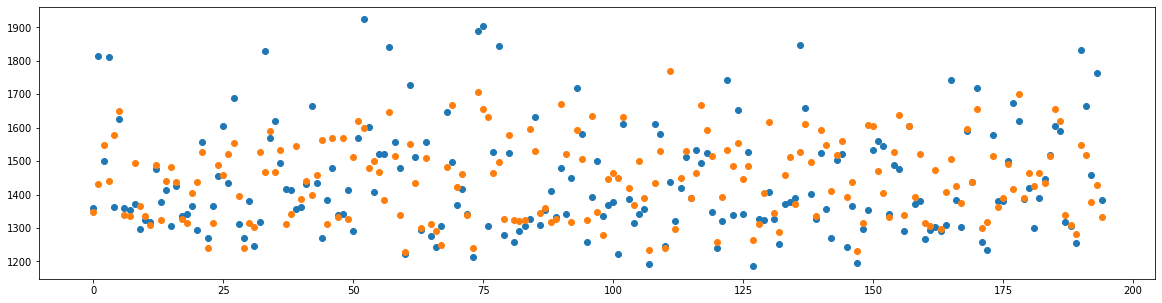

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))
plt.scatter(x,validpd['arr_time'].tolist())
predpd = h2o.as_list(pred)
plt.scatter(x,predpd['predict'].tolist())

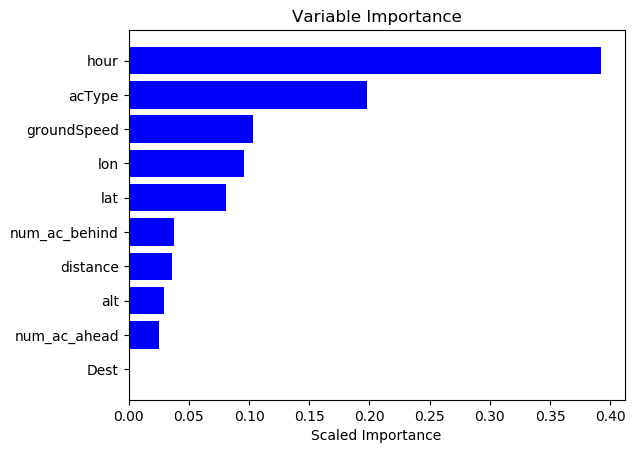

In [54]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ac_gbm._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [55]:
ac_gbm.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,hour,40137324.00,1.000000,0.392330
1,acType,20241162.00,0.504298,0.197851
2,groundSpeed,10602185.00,0.264148,0.103633
3,lon,9767593.00,0.243354,0.095475
4,lat,8263432.00,0.205879,0.080773
5,num_ac_behind,3886983.00,0.096842,0.037994
6,distance,3709500.75,0.092420,0.036259
7,alt,2979007.75,0.074220,0.029119
8,num_ac_ahead,2620282.50,0.065283,0.025612
9,Dest,97428.75,0.002427,0.000952


In [56]:
ac_gbm.rmse

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1606201694398_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,16861.0,5.0,5.0,5.0,8.0,28.0,19.1




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4753.981668458365
RMSE: 68.94912376860466
MAE: 45.93669070765113
RMSLE: 0.04403065338761133
Mean Residual Deviance: 4753.981668458365

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 16645.59614774056
RMSE: 129.01781329622884
MAE: 93.36376482896533
RMSLE: 0.08453163439840237
Mean Residual Deviance: 16645.59614774056

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-11-24 00:08:17,0.020 sec,0.0,170.982437,135.965801,29234.993650,160.527706,128.916999,25769.144275
1,,2020-11-24 00:08:17,0.161 sec,1.0,162.060244,127.772368,26263.522824,155.078572,123.453564,24049.363570
2,,2020-11-24 00:08:17,0.195 sec,2.0,154.401275,120.683604,23839.753605,150.955594,119.208754,22787.591218
3,,2020-11-24 00:08:17,0.212 sec,3.0,147.393975,114.457524,21724.983791,147.395368,116.196845,21725.394388
4,,2020-11-24 00:08:17,0.229 sec,4.0,140.687063,108.136594,19792.849790,144.128287,112.768591,20772.963019
5,,2020-11-24 00:08:17,0.245 sec,5.0,135.042309,102.972931,18236.425282,141.621291,110.398569,20056.590128
6,,2020-11-24 00:08:17,0.264 sec,6.0,129.923494,98.331503,16880.114302,139.147266,107.770071,19361.961752
7,,2020-11-24 00:08:17,0.283 sec,7.0,125.928996,94.509044,15858.112110,137.836309,106.072131,18998.847963
8,,2020-11-24 00:08:17,0.299 sec,8.0,121.687974,90.643752,14807.963116,136.484618,104.116023,18628.050913
9,,2020-11-24 00:08:17,0.314 sec,9.0,118.540982,87.438749,14051.964334,134.501633,102.321722,18090.689217



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,hour,40137324.00,1.000000,0.392330
1,acType,20241162.00,0.504298,0.197851
2,groundSpeed,10602185.00,0.264148,0.103633
3,lon,9767593.00,0.243354,0.095475
4,lat,8263432.00,0.205879,0.080773
5,num_ac_behind,3886983.00,0.096842,0.037994
6,distance,3709500.75,0.092420,0.036259
7,alt,2979007.75,0.074220,0.029119
8,num_ac_ahead,2620282.50,0.065283,0.025612
9,Dest,97428.75,0.002427,0.000952


<bound method ModelBase.rmse of >

## Prediction Intervals

### quantile regression 

In [57]:
hf = h2o.H2OFrame(pdf3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [58]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)
# train a GBM model
ac_gbm_down = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.164, seed = 1234)
ac_gbm_down.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_low = ac_gbm_down.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


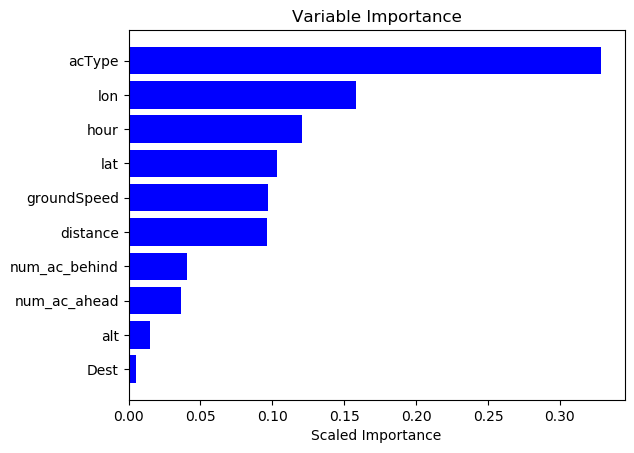

In [59]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ac_gbm_down._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_down._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [60]:
ac_gbm_up = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.837, seed = 1234)
ac_gbm_up.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_up = ac_gbm_up.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [61]:
valid.head(100)

recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40
1.56466e+09,2019-08-01 06:48:01,6,SWA6526,30.9606,-82.1322,370,KATL,367657,B738,476,162,171,1359,1.56466e+09,1.56466e+09
1.56472e+09,2019-08-01 23:36:20,23,DAL675,35.2886,-80.9208,300,KATL,369784,A321,467,189,174,1814,1.56472e+09,1.56472e+09
1.56468e+09,2019-08-01 13:50:04,13,EDV5143,38.2972,-84.4067,280,KCHA,369029,CRJ2,387,331,331,1501,1.56468e+09,1.56468e+09
1.56472e+09,2019-08-01 23:43:56,23,DAL2534,34.915,-80.7083,280,KATL,369689,MD88,465,178,172,1812,1.56472e+09,1.56472e+09
1.56469e+09,2019-08-01 15:51:35,15,NKS362,31.4497,-87.4031,348,KATL,370048,A321,435,320,332,1364,1.56469e+09,1.56469e+09
1.56469e+09,2019-08-01 15:51:30,15,DAL323,33.0217,-80.6636,330,KATL,356164,B739,426,320,334,1625,1.56469e+09,1.56469e+09
1.56466e+09,2019-08-01 06:52:21,6,DAL2653,35.4619,-81.0422,280,KATL,370056,A321,472,174,181,1361,1.56466e+09,1.56466e+09
1.56467e+09,2019-08-01 11:55:57,11,AAL2737,32.4964,-88.1478,290,KATL,369004,A321,413,366,361,1354,1.56468e+09,1.56468e+09
1.5647e+09,2019-08-01 19:45:51,19,DAL2047,30.3422,-83.9217,340,KATL,369632,B738,488,260,269,1372,1.5647e+09,1.5647e+09
1.56467e+09,2019-08-01 09:16:22,9,AWI4810,36.715,-81.6736,280,KCHA,367935,CRJ2,446,344,362,1298,1.56467e+09,1.56467e+09


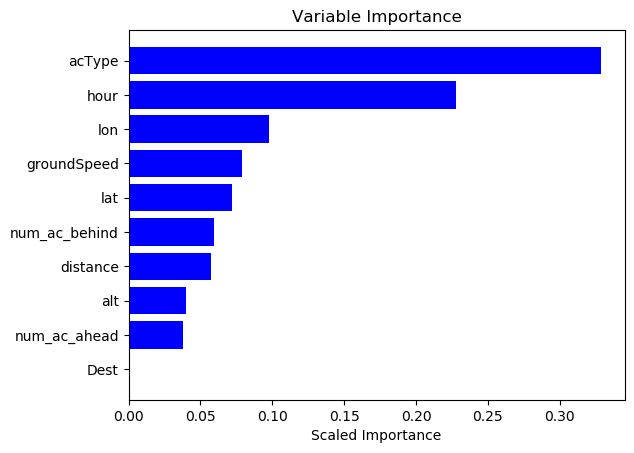

In [62]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ac_gbm_up._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_up._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

Text(0, 0.5, 'Arrival Time')

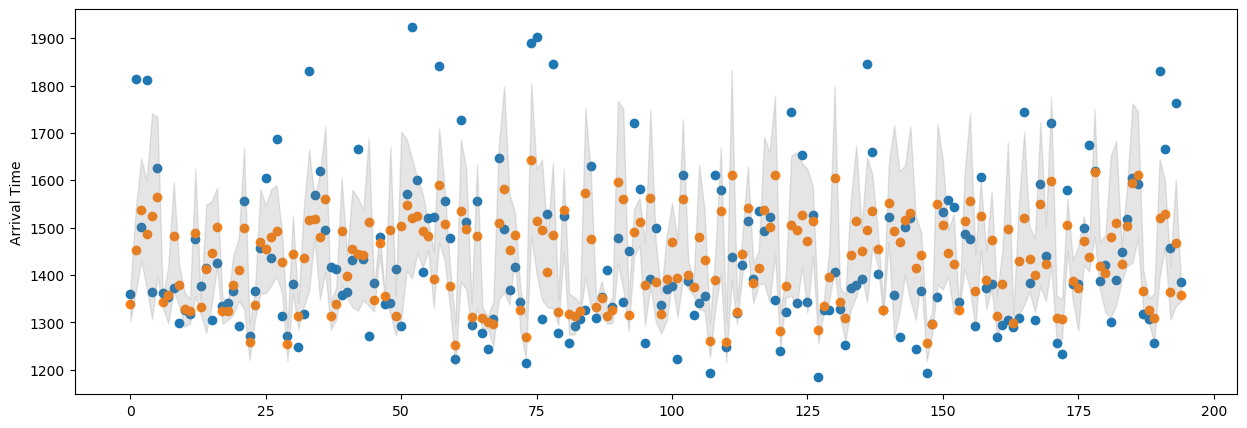

In [63]:
fig, ax= plt.subplots(figsize=(15,5))
validpd = h2o.as_list(valid)
_ = range(valid.shape[0])
plt.scatter(_,validpd['arr_time'].tolist(), marker = 'o')

err_down = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_down+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_down - pred_m, err_up-pred_m]
plt.scatter(_,pred_m, marker = 'o')
#plt.errorbar(_, pred_new, yerr=yerror, fmt='k', elinewidth=None, capsize=5, barsabove=False, ls='none')
plt.fill_between(x, err_down, err_up, color='gray', alpha=0.2)
plt.ylabel('Arrival Time')

In [64]:
yerror

[array([ -35.22372742,  -87.7352272 , -107.90091541, -113.6162344 ,
        -217.14870802, -168.48047659,  -12.76257281,  -59.66873824,
        -114.90028097,  -43.43818308,  -36.61196753,  -25.49228923,
        -134.28635846,  -14.8595574 , -135.2050462 , -109.28202398,
         -83.06009011,  -27.95084031,  -18.46963941,  -63.09830439,
         -65.50402988, -170.56134569,  -38.30672855,  -30.23885527,
        -110.41171624,  -92.79214962, -101.35205708,  -96.61807747,
         -64.44571802,  -35.22681239,  -81.55270311,  -27.69025633,
        -103.18776269, -148.97686462,  -42.37645332, -132.42954743,
        -153.59295765,  -29.82154276,  -33.94254935, -112.14094847,
         -45.62726909, -124.42745156, -119.40712309,  -96.03307715,
        -176.34541427,  -24.03934172,  -24.88209241,   -4.15472909,
        -176.91504442,  -41.1643023 , -199.31251036, -139.49812828,
        -125.99400991,  -79.15373237,  -77.07196293,  -29.21873336,
         -59.44298495, -121.276161  ,  -77.52528

## implementation in the algorithm

In [65]:
slice_data_hf = h2o.H2OFrame(slice_data)
slice_pred_up = ac_gbm_up.predict(slice_data_hf)
slice_pred_down = ac_gbm_down.predict(slice_data_hf)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [66]:
slice_data.head(100)

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time100,time40
1048300,1564684257,2019-08-01 14:30:57,14,SLI2710,31.65333,-87.58056,372.0,KATL,368479.680683,E190,448,341,340,1234,1564685026,1564685491
1047132,1564684371,2019-08-01 14:32:51,14,DAL1153,35.81778,-81.37667,300.0,KATL,368977.232715,MD90,424,339,341,1418,1564685221,1564685789
1061521,1564684546,2019-08-01 14:35:46,14,NKS808,34.75861,-88.22361,333.0,KATL,370307.253967,A320,472,345,334,1272,1564685319,1564685818
1049204,1564684417,2019-08-01 14:33:37,14,DAL2018,30.71944,-82.56750,350.0,KATL,368750.621914,B752,494,336,340,1409,1564685256,1564685826
1059600,1564684439,2019-08-01 14:33:59,14,SWA2397,31.49083,-87.42083,230.0,KATL,368275.940400,B738,422,336,340,1436,1564685314,1564685875
1060458,1564684335,2019-08-01 14:32:15,14,DAL376,30.32556,-84.13111,360.0,KATL,369453.848700,B739,470,339,341,1600,1564685156,1564685935
1059853,1564684535,2019-08-01 14:35:35,14,SKW5901,31.34750,-87.26111,270.0,KATL,368024.325639,CRJ7,470,343,334,1532,1564685447,1564686067
1070805,1564684425,2019-08-01 14:33:45,14,AAL1630,32.49556,-88.14000,250.0,KATL,368356.979861,B738,452,336,340,1702,1564685579,1564686127
1074507,1564684654,2019-08-01 14:37:34,14,SKW3974,36.61167,-82.58083,298.0,KATL,370349.007605,CRJ2,379,342,340,1623,1564685680,1564686277
1083854,1564684979,2019-08-01 14:42:59,14,EDV3482,35.18500,-87.99028,330.0,KATL,368910.496043,CRJ9,497,340,336,1367,1564685751,1564686346


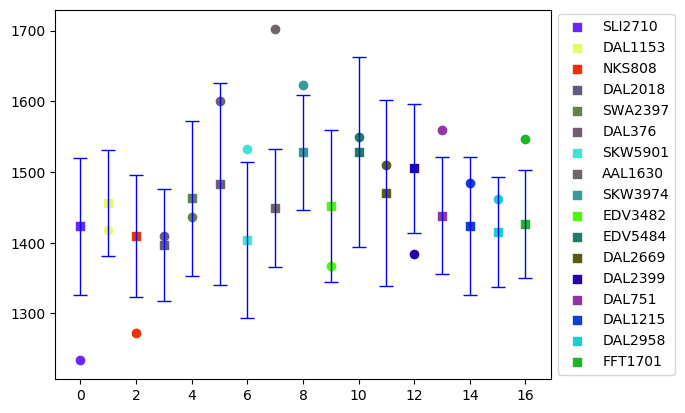

In [67]:
true_data = slice_data['arr_time'].values
err_pred_down = np.array(h2o.as_list(slice_pred_down)['predict'])
err_pred_up = np.array(h2o.as_list(slice_pred_up)['predict'])
slice_pred = (err_pred_down + err_pred_up)/2
_ = range(len(slice_pred))
yerror = [slice_pred - err_pred_down, err_pred_up-slice_pred]
plt.errorbar(_, slice_pred, yerr=yerror, fmt='b', elinewidth=1, capsize=5, barsabove=True, ls='none')

marker = ['o','s','v','^','D','<','>','h','H','p','*','8','P','d','X','x']
for i in range(len(true_data)):
    rgb = np.random.rand(3,)
    plt.scatter(_[i], slice_pred[i], marker='s', color=[rgb], label = slice_data['acId'].values[i])
    plt.scatter(_[i], true_data[i],marker='o', color = [rgb])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [88]:
(err_pred_up -err_pred_down)/2

array([156.9994302 ,  67.46089528, 391.8520895 , 140.75541282,
       155.88601681,  94.41513308, 221.86099401, 171.19731208,
       140.61802482, 315.38978268, 121.99109313, 216.87261559,
        93.43992879, 248.98665662, 238.52759681, 174.31176384,
       268.03717531])

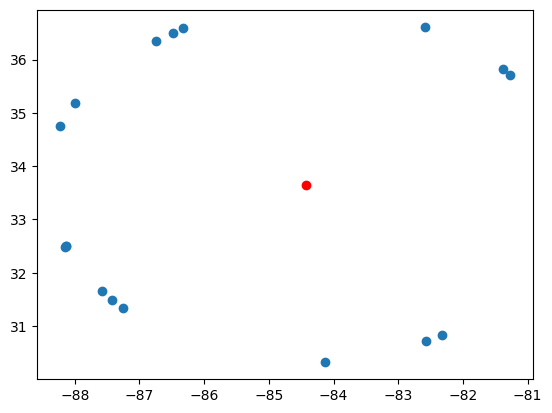

In [89]:
plt.scatter(slice_data['lon'].values, slice_data['lat'])
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], color='r')

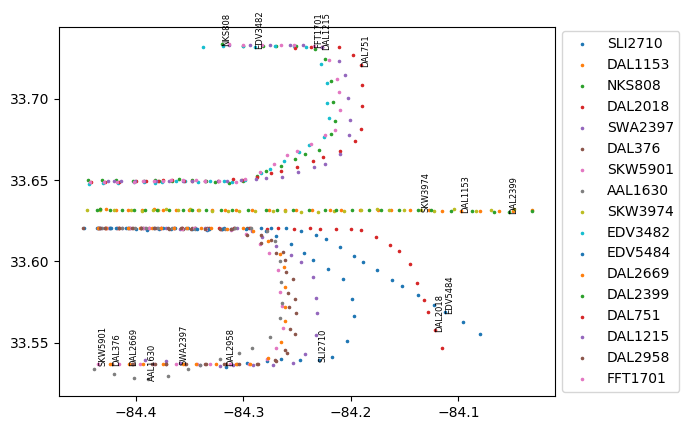

In [90]:
slice_acId = slice_data['acId'].values
#j = 0
for id in slice_acId:
    init_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['init_ac']==True].index.values[0]
    end_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['end_ac']==True].index.values
    j = np.random.randint(len(slice_acId))
    if len(end_index) > 1:
        for i in end_index:
            if pdf_rec3.loc[i]['alt'] < pdf_rec3.loc[i-100]['alt']:
                tmp = i
        end_index = tmp
    else:
        end_index = end_index[0]
    if pdf_rec3.loc[end_index]['alt'] < 20:
        tt_lat = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-30:end_index]['lat']
        tt_lon = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-30:end_index]['lon']
        plt.scatter(tt_lon.values, tt_lat.values, marker='.', label=id, s=10, linewidths=1)
        plt.text(tt_lon.values[j//3],tt_lat.values[j//3], id, rotation='vertical',fontsize=6)
        #j+=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [1034]:
'''runway1 = ['DAL2319', 'EDV5357', 'SKW3738', 'DAL2420']
runway2 = ['DAL1521']
runway3 = np.setdiff1d(slice_acId, runway1)
runway3 = np.setdiff1d(runway3, runway2)'''

"runway1 = ['DAL2319', 'EDV5357', 'SKW3738', 'DAL2420']\nrunway2 = ['DAL1521']\nrunway3 = np.setdiff1d(slice_acId, runway1)\nrunway3 = np.setdiff1d(runway3, runway2)"

In [70]:
#runway3 = ['SLI2710', 'DAL376', 'SKW5901', 'AAL1630', 'DAL2669', 'RPA4407', 'SWA2397','DAL2958', 'DAL1095','EDV5362', 'DAL2018']
#runway3 = ['AAL1630', 'DAL2669', 'DAL1095', 'EDV5362', 'EDV5484']
#runway3 = ['EDV3482', 'FFT1701', 'DAL1215', 'BTQ483', 'NKS808', 'DAL751']
runway3 = ['SKW5901', 'DAL376', 'DAL2669','AAL1630', 'SWA2397', 'EDV5362', 'DAL1095', 'EDV5484', 'DAL2018']

### use runway3 as an example

In [71]:
from pyomo.environ import *
import numpy as np
import sys
from DistributionATSP import Distribution_ATSP
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

In [72]:
def time_space(threshold, sd1, sd2):
    return threshold - norm.ppf(q = Pc, loc = 0,scale = np.sqrt(sd1**2 + sd2**2))

In [150]:
Pc = 0.1
UB = [100000]
LB = [0]
tt = [0]
items = ['acId', 'threshold', 'mean', 'sd', 'uperBound', 'lowerBound']
ac = pd.DataFrame([], columns=items)
ac['acId'] = runway3
#ac['mean']= runway3_arr_time
ac.loc[:,'threshold'] = 60


In [151]:
check = []
for id in slice_data['acId'].values:
    check.append(id in runway3)
r3_pred = np.array(slice_pred[check])
#ac['mean'] = slice_data[check]['arr_time'].values
r3_time = slice_data['recTime'][check].values
r3_time -= r3_time[-1]
ac['mean'] = r3_pred #+ r3_time
ac['sd'] = np.array(err_pred_up[check]) - r3_pred
ac['lowerBound'] = ac['mean'] - 300
ac['uperBound'] = ac['mean'] + 3600

In [152]:
ac.loc[ac[ac['lowerBound']<0].index, 'lowerBound']=0

In [153]:
runway3 = slice_data[check]['acId'].values
max_num = min(len(runway3), 8)
ac_runway3 = runway3[0:max_num]
ac_runway3

array(['DAL2018', 'SWA2397', 'DAL376', 'SKW5901', 'AAL1630', 'EDV5484',
       'DAL2669', 'DAL1095'], dtype=object)

In [154]:
check2 = []
for id in ac['acId'].values:
    check2.append(id in ac_runway3)
ac = ac[check2]


In [155]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL2018,60,556.585991,49.663685,4156.585991,256.585991
1,SWA2397,60,635.718349,68.017141,4235.718349,335.718349
2,DAL376,60,588.265077,66.139977,4188.265077,288.265077
3,SKW5901,60,646.198142,63.608483,4246.198142,346.198142
4,AAL1630,60,619.742421,64.979990,4219.742421,319.742421
5,EDV5484,60,640.894666,65.620870,4240.894666,340.894666
6,DAL2669,60,539.582035,46.805399,4139.582035,239.582035
7,DAL1095,60,647.192176,22.229275,4247.192176,347.192176


In [156]:
ac_runway3

array(['DAL2018', 'SWA2397', 'DAL376', 'SKW5901', 'AAL1630', 'EDV5484',
       'DAL2669', 'DAL1095'], dtype=object)

In [157]:
ac

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL2018,60,556.585991,49.663685,4156.585991,256.585991
1,SWA2397,60,635.718349,68.017141,4235.718349,335.718349
2,DAL376,60,588.265077,66.139977,4188.265077,288.265077
3,SKW5901,60,646.198142,63.608483,4246.198142,346.198142
4,AAL1630,60,619.742421,64.979990,4219.742421,319.742421
5,EDV5484,60,640.894666,65.620870,4240.894666,340.894666
6,DAL2669,60,539.582035,46.805399,4139.582035,239.582035
7,DAL1095,60,647.192176,22.229275,4247.192176,347.192176


In [158]:
tt = np.array([0])
tt = np.append(tt, np.array(ac['mean'].tolist()))
num_ac = len(ac_runway3)
for index, row in ac.iterrows():
    LB.append(row['lowerBound'])
    UB.append(row['uperBound'])
    tt_temp = [0]
    for ii in range(num_ac):
        if index == ii:
            space = 0
        else:
            space = time_space(row['threshold'], row['sd'], ac.loc[ii]['sd']) 
        tt_temp.append(space)
    tt=np.vstack((tt, np.array(tt_temp)))
N = num_ac
ccc = Distribution_ATSP(UB, LB, N, tt)
model = ccc.set_model()

solver = SolverFactory('glpk')
solution = solver.solve(model, tee=True)
result_time = np.zeros(N)
for i in range(N):
    result_time[i] = model.t[i+2].value
sort_index = np.argsort(result_time)
sort_time = np.sort(result_time)

GLPSOL: GLPK LP/MIP Solver, v4.57
Parameter(s) specified in the command line:
 --write /tmp/tmpa4hrh1l7.glpk.raw --wglp /tmp/tmp6cm2kjk_.glpk.glp --cpxlp
 /tmp/tmpg8q9oep5.pyomo.lp
Reading problem data from '/tmp/tmpg8q9oep5.pyomo.lp'...
/tmp/tmpg8q9oep5.pyomo.lp:1156: warning: lower bound of variable 'x11' redefined
/tmp/tmpg8q9oep5.pyomo.lp:1156: warning: upper bound of variable 'x11' redefined
196 rows, 91 columns, 468 non-zeros
81 integer variables, all of which are binary
1237 lines were read
Writing problem data to '/tmp/tmp6cm2kjk_.glpk.glp'...
956 lines were written
GLPK Integer Optimizer, v4.57
196 rows, 91 columns, 468 non-zeros
81 integer variables, all of which are binary
Preprocessing...
8 constraint coefficient(s) were reduced
90 rows, 81 columns, 344 non-zeros
72 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.168e+03  ratio =  4.168e+03
GM: min|aij| =  6.335e-01  max|aij| =  1.579e+00  ratio =  2.492e+00
EQ: min|aij| =  4.0

In [159]:
ttpd=pd.DataFrame(tt)
ttpd

,0,1,2,3,4,5,6,7,8
0,0.0,556.585991,635.718349,588.265077,646.198142,619.742421,640.894666,539.582035,647.192176
1,0.0,0.000000,167.930787,165.997394,163.421455,164.812435,165.466167,147.458050,129.731272
2,0.0,167.930787,0.000000,181.584250,179.345212,180.552597,181.121404,165.812063,151.704594
3,0.0,165.997394,181.584250,0.000000,177.599627,178.824751,179.401790,163.839229,149.421056
4,0.0,163.421455,179.345212,177.599627,0.000000,176.532705,177.121036,161.208375,146.352042
5,0.0,164.812435,180.552597,178.824751,176.532705,0.000000,178.351114,162.629354,148.013205
6,0.0,165.466167,181.121404,179.401790,177.121036,178.351114,0.000000,163.296903,148.790710
7,0.0,147.458050,165.812063,163.839229,161.208375,162.629354,163.296903,0.000000,126.404730
8,0.0,129.731272,151.704594,149.421056,146.352042,148.013205,148.790710,126.404730,0.000000


In [160]:
sort_time

array([ 539.58203546,  665.98676533,  795.71803756,  959.13949271,
       1135.67219738, 1314.0233118 , 1493.42510137, 1675.00935089])

In [161]:
sort_index

array([6, 7, 0, 3, 4, 5, 2, 1])

In [162]:
ac.set_index(sort_index, inplace=True)
ac.sort_index()

,acId,threshold,mean,sd,uperBound,lowerBound
0,DAL376,60,588.265077,66.139977,4188.265077,288.265077
1,DAL1095,60,647.192176,22.229275,4247.192176,347.192176
2,DAL2669,60,539.582035,46.805399,4139.582035,239.582035
3,SKW5901,60,646.198142,63.608483,4246.198142,346.198142
4,AAL1630,60,619.742421,64.979990,4219.742421,319.742421
5,EDV5484,60,640.894666,65.620870,4240.894666,340.894666
6,DAL2018,60,556.585991,49.663685,4156.585991,256.585991
7,SWA2397,60,635.718349,68.017141,4235.718349,335.718349


In [163]:
ac.loc[6]['acId']

'DAL2018'

In [164]:
ac[ac['acId']=='DAL2018'].index[0]

6

In [167]:
marker = ['o','s','v','^','D','d','p','v']
color = np.random.rand(8,3)
#ac_indicator = pd.DataFrame()
ac_indicator = ac[['acId']].copy()
ac_indicator['marker'] = marker
ac_indicator['color'] = color.tolist()
ac_indicator

,acId,marker,color
6,DAL2018,o,"[0.8628516421335969, 0.09479721187792767, 0.6600345062427121]"
7,SWA2397,s,"[0.37500935221695175, 0.3945810470889133, 0.6452859163473879]"
0,DAL376,v,"[0.5636457720599802, 0.1651647257608171, 0.859481554991802]"
3,SKW5901,^,"[0.6617736923959292, 0.23215823198824959, 0.6505231494006641]"
4,AAL1630,D,"[0.3090928617383577, 0.7681203236136039, 0.5227889847808947]"
5,EDV5484,d,"[0.39516845388275434, 0.48684052981296677, 0.5474079258728921]"
2,DAL2669,p,"[0.3520614885369493, 0.9986870789337573, 0.8060934818108352]"
1,DAL1095,v,"[0.4872755062010212, 0.36821464419249594, 0.014885191988552426]"


In [168]:
runway3_arr_time

[1564685826,
 1564685875,
 1564685935,
 1564686067,
 1564686127,
 1564686363,
 1564686415]

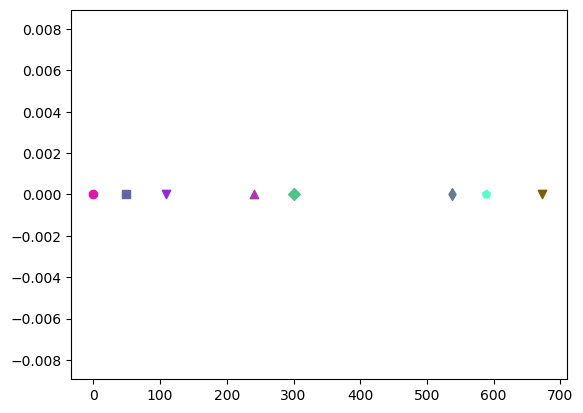

In [169]:
runway3_arr_time = []
for id in ac_runway3:
    arr_40_time = slice_data[slice_data['acId']==id]['recTime'].values[0] + slice_data[slice_data['acId']==id]['arr_time'].values[0]
    runway3_arr_time.append(arr_40_time)
i = 0
for id in ac_runway3:
    plt.scatter(np.array(runway3_arr_time)[i]-min(runway3_arr_time), 0, marker=ac_indicator[ac_indicator['acId']==id]['marker'].values[0], color=ac_indicator[ac_indicator['acId']==id]['color'].values)
    i+=1

In [170]:
ac_indicator['arr_40_time'] = runway3_arr_time

In [171]:
land_time = []
for id in ac_runway3:
    data_id = pdf_rec3[pdf_rec3['acId']==id]
    tmp_data = data_id[data_id['end_ac']==True]
    tmp_data = tmp_data[tmp_data['alt']<20]
    if tmp_data.shape[0]>1:
        tmp_data_dist2dest = haversine_vectorize(tmp_data['lat'], tmp_data['lon'], airportsCoord['KATL'][0], airportsCoord['KATL'][1])
        tmp_data_dist2dest_min = min(tmp_data_dist2dest)
        ind = tmp_data_dist2dest[tmp_data_dist2dest==tmp_data_dist2dest_min].index[0]
        tmp_data = tmp_data.loc[ind]
    land_t = data_id[data_id['alt']==np.squeeze(tmp_data['alt'])].tail(3).head(1)['recTime'].values
    land_time.append(land_t)

In [172]:
ac_indicator['land_time'] = land_time
ac_indicator['sort_time'] = np.zeros(ac_indicator.shape[0])
for i in range(ac_indicator.shape[0]):
    ac_indicator.loc[i,'sort_time'] = sort_time[i]
ac_indicator

,acId,marker,color,arr_40_time,land_time,sort_time
6,DAL2018,o,"[0.8628516421335969, 0.09479721187792767, 0.6600345062427121]",1564685826,[1564686552],1493.425101
7,SWA2397,s,"[0.37500935221695175, 0.3945810470889133, 0.6452859163473879]",1564685875,[1564686700],1675.009351
0,DAL376,v,"[0.5636457720599802, 0.1651647257608171, 0.859481554991802]",1564685935,[1564686761],539.582035
3,SKW5901,^,"[0.6617736923959292, 0.23215823198824959, 0.6505231494006641]",1564686067,[1564686838],959.139493
4,AAL1630,D,"[0.3090928617383577, 0.7681203236136039, 0.5227889847808947]",1564686127,[1564686911],1135.672197
5,EDV5484,d,"[0.39516845388275434, 0.48684052981296677, 0.5474079258728921]",1564686363,[1564687044],1314.023312
2,DAL2669,p,"[0.3520614885369493, 0.9986870789337573, 0.8060934818108352]",1564686415,[1564687221],795.718038
1,DAL1095,v,"[0.4872755062010212, 0.36821464419249594, 0.014885191988552426]",1564686498,[1564687124],665.986765


(-1.5, 3.5)

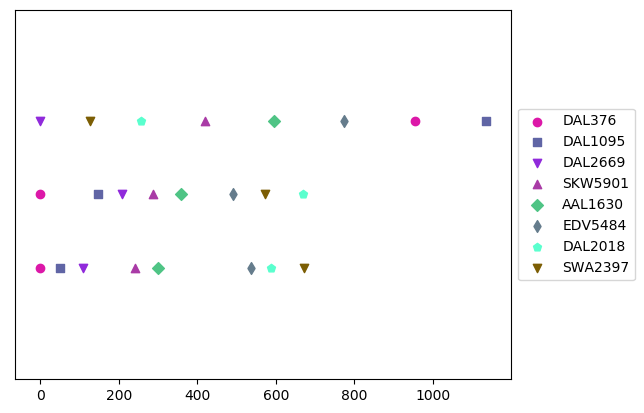

In [173]:
#marker = ['o','s','v','^','D','d','p']
arr_40_time = ac_indicator['arr_40_time'].values
land_time = ac_indicator['land_time'].values
sort_time = ac_indicator['sort_time'].values
color = ac_indicator['color'].values
marker = ac_indicator['marker'].values
label = ac_indicator['acId']

for i in range(len(land_time)):
    plt.scatter(arr_40_time[i]-min(arr_40_time), 0, color = color[i], marker = marker[i])
    plt.scatter(sort_time[i] - min(sort_time), 2, color = color[i], label = label[i], marker = marker[i])
    plt.scatter(land_time[i] - min(land_time), 1, color = color[i], marker = marker[i])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.yticks([])
plt.ylim(-1.5,3.5)

In [836]:
(sort_time - min(sort_time))*0.5

array([  0.        ,  68.33812222, 133.68067265, 198.47089478,
       266.096085  , 343.71188538, 441.90736351])

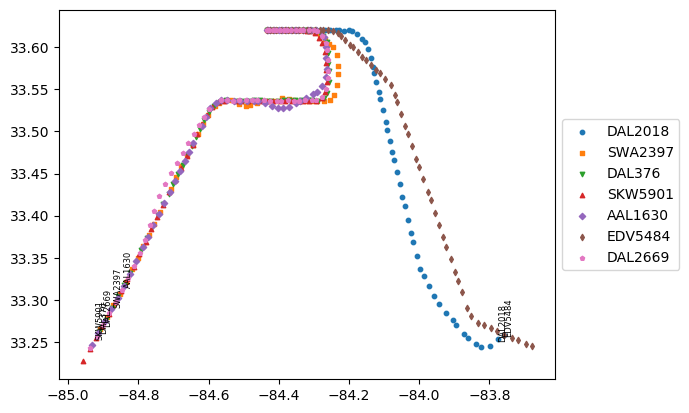

In [829]:
jj = 0
for id in ac_runway3:
    init_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['init_ac']==True].index.values[0]
    end_index = pdf_rec3[pdf_rec3['acId'] == id].loc[pdf_rec3['end_ac']==True].index.values
    j = np.random.randint(len(slice_acId))
    if len(end_index) > 1:
        for i in end_index:
            if pdf_rec3.loc[i]['alt'] < pdf_rec3.loc[i-100]['alt']:
                tmp = i
        end_index = tmp
    else:
        end_index = end_index[0]
    if pdf_rec3.loc[end_index]['alt'] < 20:
        tt_lat = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-60:end_index]['lat']
        tt_lon = pdf_rec3[pdf_rec3['acId'] == id].loc[end_index-60:end_index]['lon']
        plt.scatter(tt_lon.values, tt_lat.values, marker=marker[jj], label=id, s=10, linewidths=1)
        plt.text(tt_lon.values[j//3],tt_lat.values[j//3], id, rotation='vertical',fontsize=6)
        jj+=1
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [372]:
from h2o.grid.grid_search import H2OGridSearch

# select the values for `quantile_alpha` to grid over
hyper_params = {'quantile_alpha': [.2, .5, .8]}

# this example uses cartesian grid search because the search space is small
# and we want to see the performance of all models. For a larger search space use
# random grid search instead: {'strategy': "RandomDiscrete"}
# initialize the GBM estimator
ac_gbm_2 = H2OGradientBoostingEstimator(distribution="quantile", seed = 1234,
                                              stopping_metric = "mse", stopping_tolerance = 1e-4)

# build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(model = ac_gbm_2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

# train using the grid
grid.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

# sort the grid models by decreasing MSE
sorted_grid = grid.get_grid(sort_by = 'mse', decreasing = False)
print(sorted_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    quantile_alpha  \
0              0.5   
1              0.8   
2              0.2   

                                                        model_ids  \
0  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_2   
1  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_3   
2  Grid_GBM_py_121_sid_a626_model_python_1603474226017_94_model_1   

                  mse  
0  17903.484966387365  
1  18036.223071936613  
2  23687.845341320815  



In [373]:
valid[0,:]

time,partDay,acId,lat,lon,alt,Dest,acType,num_ac_ahead,num_ac_behind,arr_time
2019-06-24 00:55:03,0,DAL875,34.805,-83.0131,338,KATL,MD88,23,25,486


### sklearn

In [374]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection as xval
from sklearn.datasets import fetch_openml
import forestci as fci

In [375]:
pdf3_dummy = pd.get_dummies(pdf3, columns=['Dest','acType'])

In [376]:
data = pdf3_dummy.drop(['time','acId'], axis=1)

In [377]:
features_df = data.drop(['arr_time'],axis=1)
feature_list = list(features_df.columns)
features = np.array(features_df)
labels = np.array(data['arr_time'])

In [378]:
train_features, test_features, train_labels, test_labels = xval.train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [379]:
n_trees = 2000
rf = RandomForestRegressor(n_estimators = n_trees, random_state = 42)
rf.fit(train_features, train_labels)
rf_pred = rf.predict(test_features)
rf_V_IJ_unbiased = fci.random_forest_error(rf, train_features, test_features, calibrate=True)

/home/pzhao28/anaconda3/lib/python3.7/site-packages/forestci/calibration.py:102: RuntimeWarning: invalid value encountered in true_divide
  g_eta_main = g_eta_raw / sum(g_eta_raw)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


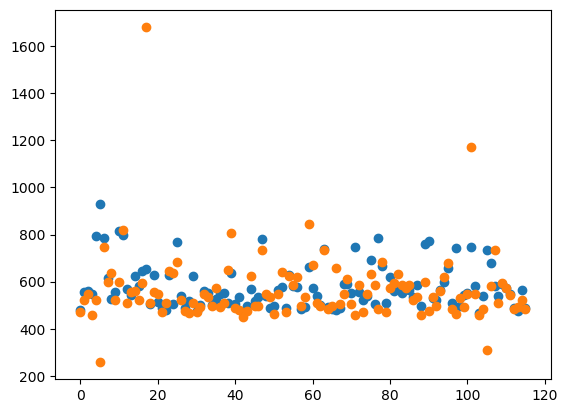

In [380]:
x = np.arange(0,len(rf_pred))
plt.scatter(x, rf_pred)
plt.scatter(x, test_labels)
print(rf_V_IJ_unbiased)
#plt.errorbar(test_labels, rf_pred, yerr=np.sqrt(rf_V_IJ_unbiased), fmt='o')

In [381]:
rf_pred

array([480.3005, 556.022 , 560.752 , 546.773 , 794.3075, 929.468 ,
       785.839 , 616.6245, 526.9835, 554.031 , 813.6095, 799.8925,
       566.731 , 543.624 , 623.95  , 580.6585, 646.153 , 653.008 ,
       504.66  , 629.6845, 514.305 , 488.0375, 480.7165, 627.3565,
       504.3965, 770.145 , 539.2215, 487.99  , 517.5475, 624.702 ,
       476.5465, 499.9445, 562.2195, 553.579 , 502.0865, 526.643 ,
       546.3915, 551.218 , 507.7175, 638.423 , 507.1385, 534.326 ,
       472.195 , 494.567 , 570.563 , 516.6055, 533.2275, 780.8315,
       539.9545, 488.6295, 494.7415, 565.6895, 578.23  , 486.427 ,
       629.4105, 579.594 , 575.522 , 484.688 , 493.7235, 660.08  ,
       572.119 , 539.5205, 500.682 , 740.1375, 492.4725, 485.2225,
       480.9175, 490.1455, 591.4765, 590.332 , 550.8045, 745.629 ,
       557.896 , 520.4425, 537.7145, 689.751 , 503.9905, 785.281 ,
       667.613 , 509.3435, 618.548 , 559.869 , 570.905 , 551.309 ,
       568.6875, 562.543 , 534.951 , 585.9615, 494.7085, 759.6

<ErrorbarContainer object of 3 artists>

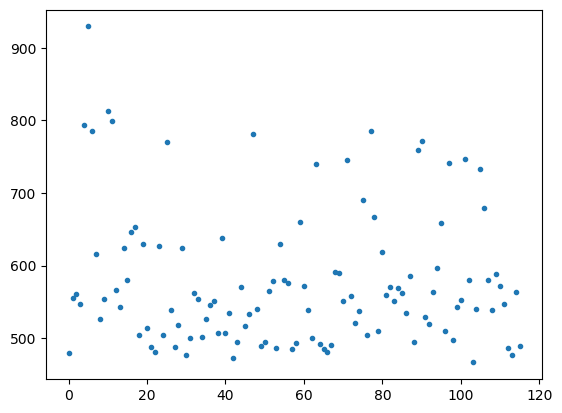

In [382]:
plt.errorbar(x, rf_pred, yerr=np.sqrt(rf_V_IJ_unbiased), fmt='.')

In [383]:
rf_V_IJ_unbiased

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [384]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict([X[x]]))
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

In [385]:
err_down, err_up = pred_ints(rf, test_features, percentile=100*(1-1e-6))

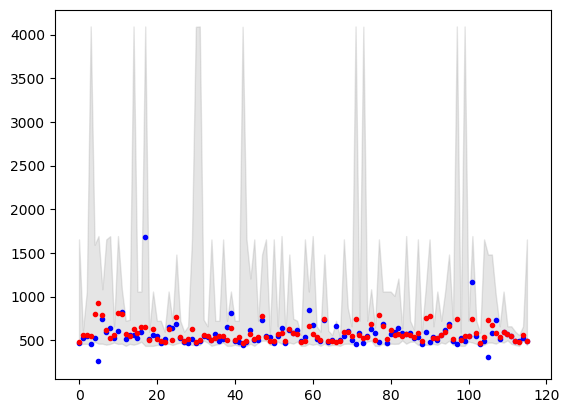

In [386]:
plt.fill_between(x, err_down, err_up, color='gray', alpha = 0.2)
plt.scatter(x, test_labels, marker = '.', color = 'b')
plt.scatter(x, rf_pred, marker = '.', color = 'r')

In [387]:
rf_most_important = RandomForestRegressor(n_estimators=1000, random_state = 42)

In [388]:
importances = rf.feature_importances_

In [389]:
importances

array([1.54217756e-02, 5.40374917e-02, 3.08951588e-01, 1.34309399e-01,
       4.14883008e-02, 2.92097968e-02, 1.62552249e-03, 7.08219239e-03,
       2.37626728e-03, 1.09824886e-03, 1.04113153e-05, 1.42675291e-04,
       9.10194089e-03, 5.87647779e-04, 2.74980715e-06, 1.08703882e-05,
       3.52933744e-03, 2.02272975e-03, 7.98057085e-04, 3.27604387e-04,
       1.68043438e-01, 5.96255303e-02, 0.00000000e+00, 2.82006507e-04,
       5.80124593e-05, 5.23222462e-05, 1.03174642e-04, 2.01209636e-05,
       5.84455041e-06, 1.22724700e-02, 0.00000000e+00, 8.90974147e-02,
       6.35482307e-05, 4.68033934e-06, 1.13111227e-03, 0.00000000e+00,
       8.46666882e-04, 5.22959781e-02, 5.03711114e-04, 9.10692009e-05,
       3.36127522e-05, 1.68997497e-04, 3.81436992e-04, 0.00000000e+00,
       1.32027036e-04, 7.22199071e-05, 2.65956052e-06, 3.38868318e-05,
       1.12735724e-04, 1.18521573e-04, 1.88113424e-05, 1.93643438e-03,
       3.56947919e-04])

([<matplotlib.axis.XTick at 0x7fd817934c50>,
 <a list of 53 Text xticklabel objects>)

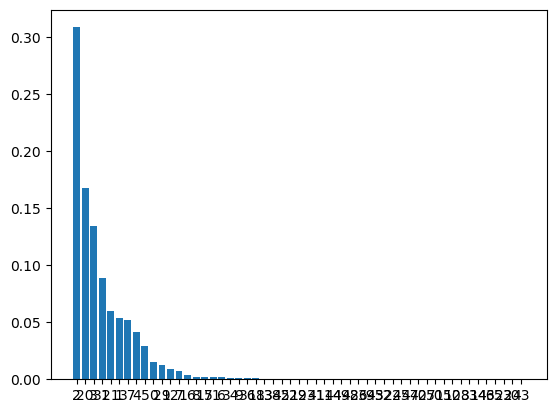

In [390]:
indices = np.argsort(importances)[::-1]
plt.bar(range(train_features.shape[1]), importances[indices], align='center')
plt.xticks(range(train_features.shape[1]), indices)

In [391]:
indices

array([ 2, 20,  3, 31, 21,  1, 37,  4,  5,  0, 29, 12,  7, 16,  8, 17, 51,
        6, 34,  9, 36, 18, 13, 38, 42, 52, 19, 23, 41, 11, 44, 49, 48, 26,
       39, 45, 32, 24, 25, 47, 40, 27, 50, 15, 10, 28, 33, 14, 46, 35, 22,
       30, 43])

In [392]:
feature_list

['partDay',
 'lat',
 'lon',
 'alt',
 'num_ac_ahead',
 'num_ac_behind',
 'Dest_KATL',
 'Dest_KCHA',
 'Dest_KGSP',
 'Dest_KHSV',
 'acType_A306',
 'acType_A319',
 'acType_A320',
 'acType_A321',
 'acType_A332',
 'acType_A333',
 'acType_B190',
 'acType_B712',
 'acType_B737',
 'acType_B738',
 'acType_B739',
 'acType_B744',
 'acType_B748',
 'acType_B752',
 'acType_B753',
 'acType_B763',
 'acType_B764',
 'acType_B77L',
 'acType_B77W',
 'acType_BE20',
 'acType_C172',
 'acType_C208',
 'acType_C525',
 'acType_C560',
 'acType_C680',
 'acType_C750',
 'acType_CRJ2',
 'acType_CRJ7',
 'acType_CRJ9',
 'acType_E135',
 'acType_E145',
 'acType_E170',
 'acType_E190',
 'acType_E45X',
 'acType_E545',
 'acType_E75L',
 'acType_E75S',
 'acType_EA50',
 'acType_F2TH',
 'acType_FA20',
 'acType_H25B',
 'acType_MD88',
 'acType_MD90']